In [22]:
import numpy as np
import os.path as osp
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import comb
from scipy.stats import sem, entropy
from models import LCALSTM
from utils.params import P
from data.ExpRun import process_cache
from data.StimGen import RNR_COND_DICT as cond_dict
from utils.io import build_log_path, load_ckpt, pickle_load_dict
from utils.constants import rnr_log_fnames
from analysis import compute_predacc, compute_dks

from analysis.utils import process_trial_type_info, \
    compute_correct_rate_wrapper, form_df, compute_mb, compute_rt, \
    extrat_trials, compute_baseline, compute_evidence, sigmoid

from analysis import compute_predacc, compute_dks, get_baseline
from matplotlib.ticker import FormatStrFormatter

from plt_helper import plot_pred_acc_rcl

sns.set(style='white', context='talk', palette='colorblind')

log_root = '/tigress/qlu/logs/learn-hippocampus/log/'

In [24]:
'''input args'''
exp_name = 'multi_lure'
subj_id = 0
penalty = 8
epoch_load = 300
n_epoch = 2000
n_mvs_rnr = 3
n_param = 11
n_hidden = 128
learning_rate = 1e-3

In [25]:
'''fixed params'''
# log params
p = P(
    exp_name=exp_name,
    n_param=n_param,  penalty=penalty, n_hidden=n_hidden, lr=learning_rate,
)
p.env.rnr.n_mvs = n_mvs_rnr
n_mems = n_mvs_rnr-1

# create logging dirs
log_path, log_subpath = build_log_path(subj_id, p, log_root=log_root)
ckpt_template, save_data_fname = rnr_log_fnames(epoch_load, n_epoch)
data_dict = pickle_load_dict(osp.join(log_subpath['rnr-data'], save_data_fname))

# unpack data
[C, V, Scalar, Vector] = data_dict['model_acts']
[Y_encs, Y_rcl, Y_hat] = data_dict['data_labels']
[memory_ids, trial_type_info] = data_dict['data_metadata']

Use exisiting dir: 
/tigress/qlu/logs/learn-hippocampus/log/exp-multi_lure/p-11_b-3/pad-1/tp-0.33/p_rm_ob_rcl-0.00_enc-0.00/lp-8/enc-cum_size-12/rp-LCA_metric-cosine/h-128/lr-0.001/subj-0
- use exisiting sub dir: ckpts
- use exisiting sub dir: data
- use exisiting sub dir: figs
- use exisiting sub dir: rnr-data
- use exisiting sub dir: rnr-ckpts
- use exisiting sub dir: rnr-figs


In [26]:
"""split data"""
# compute trial type info
tt_info = process_trial_type_info(trial_type_info)
trial_types, n_trial_types, trial_ids_set, n_trials = tt_info
n_trials_total = np.sum(n_trials)
trial_type_names = list(cond_dict.values())
print('number of trials per condition: ', n_trials)

# split the data by trial type
memory_ids_atp = [memory_ids[trial_ids_] for trial_ids_ in trial_ids_set]

Scalar_atp = np.array([extrat_trials(Scalar, trial_ids_) for trial_ids_ in trial_ids_set])
Vector_atp = np.array([extrat_trials(Vector, trial_ids_) for trial_ids_ in trial_ids_set])

C_atp = [extrat_trials(C, trial_ids_) for trial_ids_ in trial_ids_set]
V_atp = [extrat_trials(V, trial_ids_) for trial_ids_ in trial_ids_set]
Y_rcl_atp = [extrat_trials(Y_rcl, trial_ids_) for trial_ids_ in trial_ids_set]

Y_encs = [[Y_encs[i][m].data.numpy() for m in range(n_mems)] for i in range(n_trials_total)]
Y_encs_atp = np.squeeze([extrat_trials(Y_encs, trial_ids_) for trial_ids_ in trial_ids_set])

Y_hat_atp = np.array([extrat_trials(Y_hat, trial_ids_) for trial_ids_ in trial_ids_set])

predacc_atp = [compute_predacc(Y_rcl_atp[j], Y_hat_atp[j])[:,:-1] for j in range(n_trial_types)]
dks_atp = [compute_dks(Y_hat_atp[j])[:,:-1] for j in range(n_trial_types)]

np.shape(Y_hat)
np.shape(Y_rcl)

number of trials per condition:  [510, 510]


(1024, 12, 33)

(0.05835859070892461, 1.044840067109099)

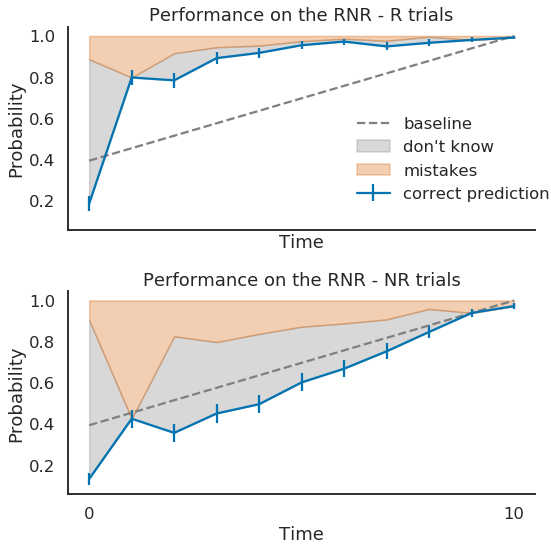

In [27]:
n_se = 2
tt_id_ = 0

pa_mu = np.mean(predacc_atp[tt_id_],axis=0)
pa_er = sem(predacc_atp[tt_id_], axis=0) * n_se
dk_probs_mu = np.mean(dks_atp[tt_id_], axis=0)
dk_probs_er = sem(dks_atp[tt_id_], axis=0) * n_se
#
pa_or_dk_mu = pa_mu + dk_probs_mu

# title = 'RNR performance'
f, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
plot_pred_acc_rcl(
    pa_mu, pa_er, pa_or_dk_mu, p,
    f, axes[0],
    alpha=.3, legend_on=True,
    title='Performance on the RNR - R trials',
)


tt_id_ = 1

pa_mu = np.mean(predacc_atp[tt_id_],axis=0)
pa_er = sem(predacc_atp[tt_id_], axis=0) * n_se
dk_probs_mu = np.mean(dks_atp[tt_id_], axis=0)
dk_probs_er = sem(dks_atp[tt_id_], axis=0) * n_se
#
pa_or_dk_mu = pa_mu + dk_probs_mu

# title = 'RNR performance'
plot_pred_acc_rcl(
    pa_mu, pa_er, pa_or_dk_mu, p,
    f, axes[1],
    alpha=.3,
    title='Performance on the RNR - NR trials',
)
axes[0].set_ylim(axes[1].get_ylim())

In [28]:
# f, ax = plt.subplots(1, 1, figsize=(8, 4))
# for j in range(2):
#     ax.plot(np.mean(predacc_atp[j], axis=0))
# f.legend(['R', 'NR'],frameon=False)
# sns.despine()
# f.tight_layout()

In [29]:
# f, ax = plt.subplots(1, 1, figsize=(8, 4))
# for j in range(2):
#     ax.plot(np.mean(dks_atp[j], axis=0))
# f.legend(['R', 'NR'],frameon=False)
# sns.despine()
# f.tight_layout()    

In [30]:
'''analyze data'''

# compute correct rate
corrects = [
    compute_correct_rate_wrapper(
        Y_rcl, Y_hat[:, :, :-1], trial_ids_set[j])[:, :-1]
    for j in range(n_trial_types)
]
# form df for plotting
corrects_dfs = [form_df(corrects_j) for corrects_j in corrects]

# compute lstm smilarity between cell states vs. memories
model_sim = [None] * n_trial_types
for j in range(n_trial_types):
    model_sim[j] = compute_evidence(
        C_atp[j], V_atp[j],
        Scalar_atp[j][:, :, 0], Scalar_atp[j][:, :, 1], Scalar_atp[j][:, :, 2],
        p.net.recall_func, p.net.kernel
    )

#
n_chunks = p.env.event_len//p.net.enc_size
n_mems_total = n_chunks * n_mems

# compute stats , NR trials
model_sim_nr = np.mean(model_sim[1], axis=1)
# compute, R trials
model_sim_r = model_sim[0]
model_sim_r_targ = np.zeros((p.env.event_len, n_chunks, n_trials[0]))
model_sim_r_lure = np.zeros((p.env.event_len, (n_mems-1)*n_chunks, n_trials[0]))
# separate target vs. lures
for i in range(n_trials[0]):
    targ_id_ = int(memory_ids_atp[0][i])
    targ_ids = np.arange(targ_id_*n_chunks, (targ_id_+1)*n_chunks)
    lure_ids = list(set(range(n_mems_total)).difference(set(targ_ids)))
    model_sim_r_targ[:, :, i] = model_sim_r[:, targ_ids, i]
    model_sim_r_lure[:, :, i] = model_sim_r[:, lure_ids, i]

(12, 1, 510)

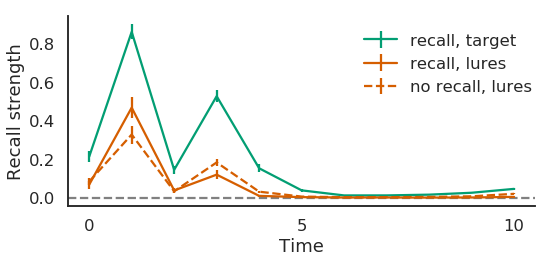

In [31]:
'''plot params'''
dpi = 150
ci_val = 99
n_se = 3
alpha_val = .05
# target-lure pallete
tl_pals = sns.color_palette(
    'colorblind', n_colors=4, desat=1)[-n_trial_types:]
# trial type params
tt_pals = sns.color_palette(n_colors=n_trial_types)

# behavioral chance
predacc_baseline = get_baseline(n_param, p.env.chance)
# predacc_baseline = np.append(predacc_baseline, 1)

'''compute model similarity / recall strength
'''

# compute stats
# NR
model_sim_nr_mu = np.mean(model_sim_nr, axis=1)

model_sim_nr_eb = sem(model_sim_nr, axis=1) * n_se
# R
model_sim_r_lure_ = np.mean(model_sim_r_lure, axis=1)
model_sim_r_targ_ = np.mean(model_sim_r_targ, axis=1)

model_sim_r_targ_mu = np.mean(model_sim_r_targ_, axis=1)
model_sim_r_targ_eb = sem(model_sim_r_targ_, axis=1) * n_se
model_sim_r_lure_mu = np.mean(model_sim_r_lure_, axis=1)
model_sim_r_lure_eb = sem(model_sim_r_lure_, axis=1) * n_se

f, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.errorbar(
    range(p.env.n_param), y=model_sim_r_targ_mu[:-1], yerr=model_sim_r_targ_eb[:-1],
    color=tl_pals[0])
ax.errorbar(
    range(p.env.n_param), y=model_sim_r_lure_mu[:-1], yerr=model_sim_r_lure_eb[:-1],
    color=tl_pals[1])
ax.errorbar(
    range(p.env.n_param), y=model_sim_nr_mu[:-1], yerr=model_sim_nr_eb[:-1],
    linestyle='--', color=tl_pals[1])
f.legend(['recall, target', 'recall, lures', 'no recall, lures'],
         frameon=False, bbox_to_anchor=(.95, .85))
ax.axhline(0, color='grey', linestyle='--')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# ax.set_title('memory activation during recall for target vs. lures')
ax.set_ylabel('Recall strength')
ax.set_xlabel('Time')
ax.set_xticks(np.arange(0, p.env.n_param, 5))
sns.despine()
f.tight_layout()

# img_name = f'e{epoch_load}-rmdnd{lesion_recall}-recall-str.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

'''scratch'''
np.shape(corrects)
np.shape(model_sim_nr)
np.shape(model_sim_r_targ)
np.shape(model_sim_r_lure)


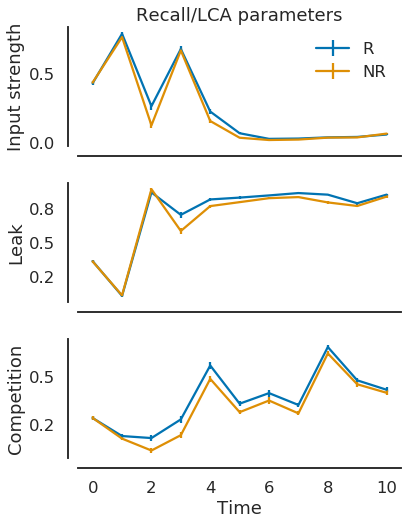

In [32]:
'''visualize scalar signals'''

def plot_time_series(
    ax, array_2d, color, 
    ylabel='', title='',
):
    Scalar_j_mu = np.mean(array_2d[:, :-1], axis=0)
    Scalar_j_se = sem(array_2d[:, :-1], axis=0) * n_se
    ax.errorbar(range(p.env.event_len-1), Scalar_j_mu, Scalar_j_se, color=color)
    # 
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


n_ssig = 3
ssig_names = ['Input strength', 'Leak', 'Competition']
f, axes = plt.subplots(n_ssig, 1, figsize=(6, 2.5*n_ssig), sharex=True)
for j in range(n_trial_types):
    for i_s in range(n_ssig):
        plot_time_series(
            axes[i_s], 
            Scalar_atp[j][:, :, i_s],
            tt_pals[j], ssig_names[i_s], 
        )
        
axes[0].set_title('Recall/LCA parameters')
axes[-1].set_xlabel('Time')
axes[0].legend(trial_type_names, frameon=False)
f.tight_layout()
sns.despine(offset=10)
# img_name = f'e{epoch_load}-rmdnd{lesion_recall}-recall-params.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)


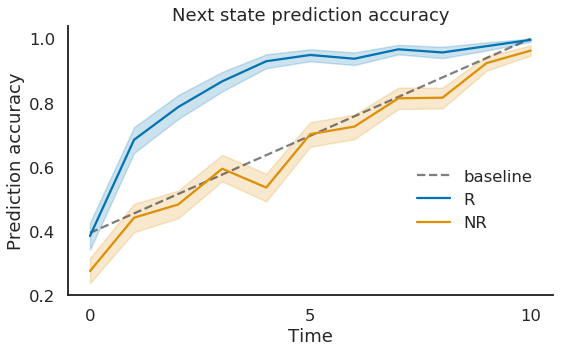

In [19]:
"""
visualize prediction accs results, all phases
"""

# plot
ci_val = 95
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(predacc_baseline[1:], color='black', linestyle='--', alpha=.5)
for j in range(n_trial_types):
    sns.lineplot(
        x='time', y='val',
        ci=ci_val,
        data=corrects_dfs[j],
        ax=ax
    )
# ax.axvline(pad_length-1, color='red', linestyle='--', alpha=.3)
# ax.axhline(predacc_chance, color='grey', linestyle='--', alpha=.5)
# ax.axhline(1, color='grey', linestyle='--', alpha=.5)

title_text = f'Next state prediction accuracy'
ax.set_title(title_text)
ax.set_ylabel('Prediction accuracy')
ax.set_xlabel('Time')
f.legend(['baseline']+trial_type_names,
         frameon=False, bbox_to_anchor=(.95, .55))
# ax.set_ylim([predacc_chance-.05, None])
# if pad_length > 1:
#     ax.set_xlim([pad_length-1, None])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_xticks(np.arange(0, p.env.event_len, 5))
sns.despine()
f.tight_layout()
# img_name = f'e{epoch_load}-rmdnd{lesion_recall}-pacc-recall.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

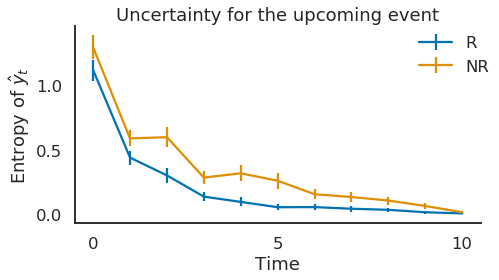

In [20]:
'''
entropy of the prediction
'''
# compute average entropy for the R/NR trials 
ents = [np.zeros((n_trials[i], n_param)) for i in range(n_trial_types)]
for j in range(n_trial_types):
    for tid in range(n_trials[j]):
        # select action prob from trial type j and trial i
        Y_probs_ji = Y_hat[trial_ids_set[j]][tid,:,:].T
        # compute the distritbuion over time
        Y_probs_ji_without_dk = Y_probs_ji[:-1, :]
        ents[j][tid, :] = [
            entropy(Y_probs_ji_without_dk[:,t]) for t in range(n_param)
        ]
        
# plot 
f, ax = plt.subplots(1, 1, figsize=(7, 4))
for j in range(n_trial_types):
    # compute summary stats    
    ent_mu_ = np.mean(ents[j], axis=0)    
    ent_er_ = sem(ents[j], axis=0) * n_se    
    ax.errorbar(x=range(n_param), y=ent_mu_, yerr=ent_er_)

ax.set_ylabel(r'Entropy of $\hat{y}_t$')
ax.set_title('Uncertainty for the upcoming event')
ax.set_xlabel('Time')
ax.set_xticks(np.arange(0,p.env.event_len,5))
f.legend(trial_type_names, frameon=False, bbox_to_anchor=(1, .9))

ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
f.tight_layout()
sns.despine()

# img_name = f'e{epoch_load}-rmdnd{lesion_recall}-ent-all.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)


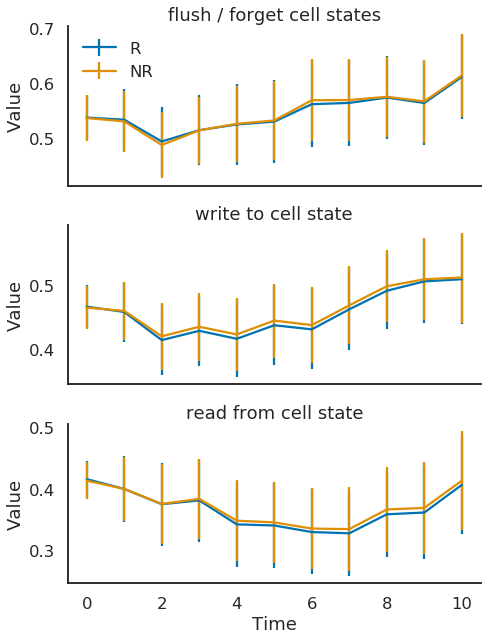

In [21]:
# list all gates
names_plt = [
    'flush / forget cell states',
    'write to cell state',
    'read from cell state'
]

f, axes = plt.subplots(3, 1, figsize=(7, 9), sharex=True)
for j in range(n_trial_types):
    for i, ax in enumerate(axes):
        data_ = Vector_atp[j, :, :-1, :, i]
        mean_gate_val = np.mean(np.mean(data_, axis=-1), axis=0)
        std_gate_val = np.mean(sem(data_, axis=-1)*n_se, axis=0)
        ax.errorbar(x=range(len(mean_gate_val)),
                    y=mean_gate_val, yerr=std_gate_val)
        ax.set_title(names_plt[i])
        ax.set_ylabel('Value')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].legend(trial_type_names, frameon=False)
axes[-1].set_xlabel('Time')
f.tight_layout()
sns.despine()

# img_name = f'e{epoch_load}-rmdnd{lesion_recall}-vsigs.png'
# f.savefig(osp.join(img_path, img_name))

In [37]:
from sklearn import metrics

def compute_roc(distrib_noise, distrib_signal):
    """compute ROC given the two distribributions
    assuming the distributions are the output of np.histogram

    example:
    dist_l, _ = np.histogram(acts_l, bins=n_bins, range=histrange)
    dist_r, _ = np.histogram(acts_r, bins=n_bins, range=histrange)
    tprs, fprs = compute_roc(dist_l, dist_r)

    Parameters
    ----------
    distrib_noise : 1d array
        the noise distribution
    distrib_signal : 1d array
        the noise+signal distribution

    Returns
    -------
    1d array, 1d array
        the roc curve: true positive rate, and false positive rate

    """
    assert len(distrib_noise) == len(distrib_signal)
    assert np.sum(distrib_noise) == np.sum(distrib_signal)
    n_pts = len(distrib_noise)
    tpr, fpr = np.zeros(n_pts), np.zeros(n_pts)
    # slide the decision boundary from left to right
    for b in range(n_pts):
        fn, tp = np.sum(distrib_signal[:b]), np.sum(distrib_signal[b:])
        tn, fp = np.sum(distrib_noise[:b]), np.sum(distrib_noise[b:])
        # calculate TP rate and FP rate
        tpr[b] = tp / (tp + fn)
        fpr[b] = fp / (tn + fp)
    return tpr, fpr

def compute_auc_over_time(
        acts_l, acts_r,
        n_bins=100, histrange=(0, 1)
):
    """compute roc, auc
    - given the activity for the two conditions
    - compute roc, auc for all time points
    """
    event_len, n_examples = np.shape(acts_l)
    # compute fpr, tpr
    tprs = np.zeros((event_len, n_bins)) 
    fprs = np.zeros((event_len, n_bins))
    for t in range(event_len):
        # compute the bin counts for each condition
        dist_l, _ = np.histogram(acts_l[t, :], bins=n_bins, range=histrange)
        dist_r, _ = np.histogram(acts_r[t, :], bins=n_bins, range=histrange)
        tprs[t], fprs[t] = compute_roc(dist_l, dist_r)
    # compute area under roc cureves
    auc = [metrics.auc(fprs[t], tprs[t]) for t in range(event_len)]
    return tprs, fprs, auc

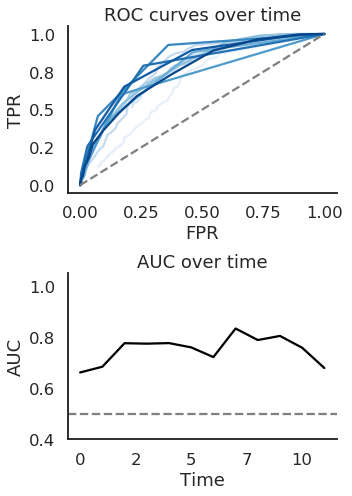

In [38]:
'''signal detction metric - max score, compare trial types
'''

# np.shape(model_sim)
n_bins = 100
histrange = (0, 1)
max_acts = np.max(model_sim, axis=2)
tprs, fprs, auc = compute_auc_over_time(
    max_acts[1], max_acts[0], n_bins=n_bins, histrange=histrange)

# compute the average/max AUC over time
avg_auc = np.mean(auc)
max_auc = np.max(auc)

cur_pal = sns.color_palette('Blues', n_colors=n_param)

f, axes = plt.subplots(2, 1, figsize=(5, 7))
for t in range(n_param):
    axes[0].plot(fprs[t], tprs[t], color=cur_pal[t])
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title('ROC curves over time')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='grey')

axes[1].plot(auc, color='black')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('AUC')
axes[1].set_title('AUC over time')
# axes[1].set_title('AUC over time, mean = %.2f' % (np.mean(auc)))
axes[1].axhline(.5, linestyle='--', color='grey')
axes[1].set_ylim([.4, 1.05])

for ax in axes:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%d'))
f.tight_layout()
sns.despine()
# img_name = f'e{epoch_load}-auc-ms.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

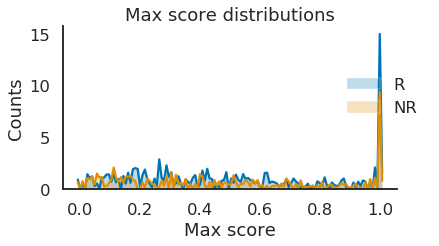

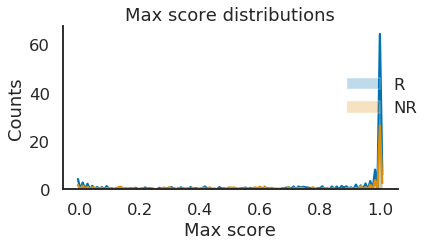

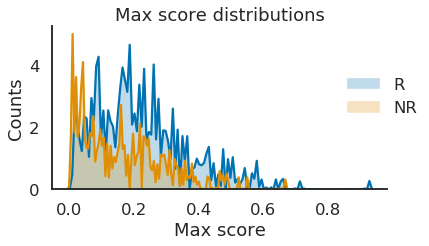

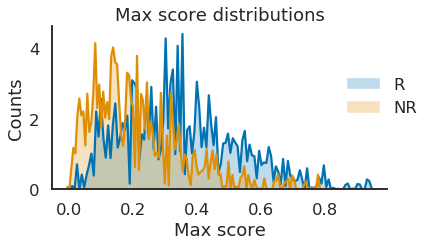

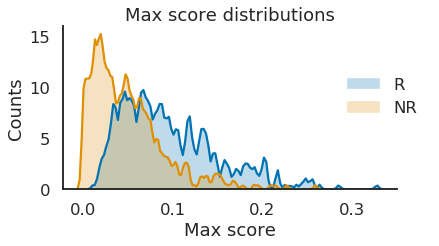

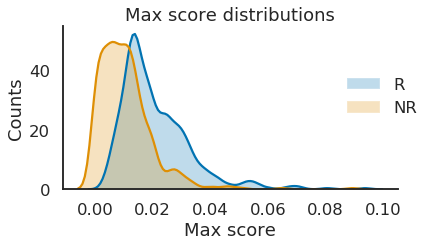

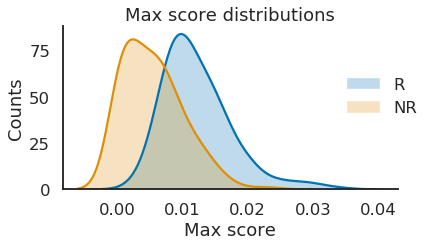

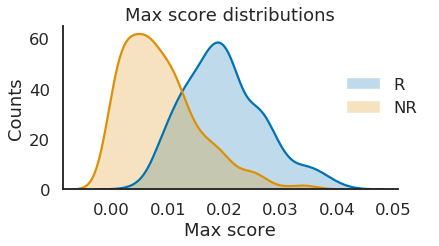

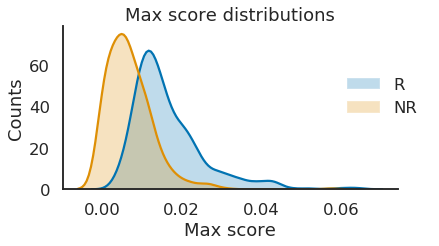

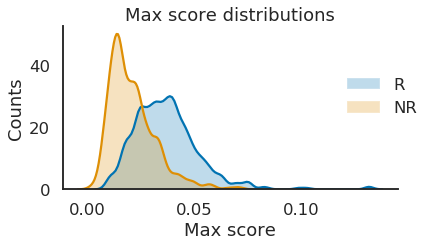

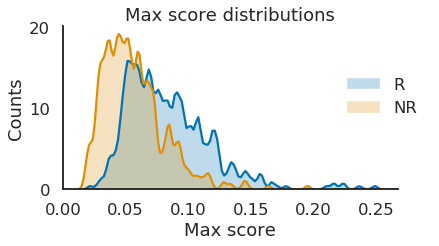

In [69]:
n_bins = 500
vmin = np.min(max_acts)
vmax = np.max(max_acts)
# vmin = np.min(max_acts[:, t, :])
# vmax = np.max(max_acts[:, t, :])
bw = (vmax - vmin) / n_bins

for t in range(n_param):
    f, ax = plt.subplots(1, 1, figsize=(6, 3))
    for j in range(n_trial_types):
        sns.kdeplot(
            max_acts[j, t, :],
            shade=True,
            bw=bw,
            ax=ax,
            shade_lowest=True,
        )
    ax.set_title('Max score distributions')
    ax.set_xlabel('Max score')
    ax.set_ylabel('Counts')
    # ax.set_xlim([-.2, 1.2])
    # ax.set_xlim([vmin*.9, vmax*1.1])
    # ax.set_ylim([0, 9])
    f.legend(trial_type_names, frameon=False, bbox_to_anchor=(1, .85))
    sns.despine()
#     img_name = f'e{epoch_load}_ms-dist-t{t}.png'
#     f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

In [72]:
# print(log_path)
#
# j = 0
# np.shape(Y_rcl_atp[j])

# for r trials, compute the similarity between target vs. lure
j = 0
# compute the number of params shared across lures
n_p_shared = np.zeros((n_trials[j], n_lures))
# compute the memory benefit for all trials
memory_benefits = np.zeros((n_trials[j], ))

for i in range(n_trials[j]):
    # get the target info
    targ_id = int(memory_ids_atp[j][i])
    targ_mem_i = Y_encs_atp[j][i][targ_id]
    targ_mem_vec_i = np.sum(targ_mem_i, axis=0)
    # loop over all lures, compute target-lure similarity
    lure_mem_vecs_i = []
    for m in set(range(p.env.rnr.n_mvs-1)).difference({targ_id}):
        lure_mem_vec_m = np.sum(Y_encs_atp[j][i][m], axis=0)
        lure_mem_vecs_i.append(lure_mem_vec_m)
    n_p_shared[i, :] = [
        np.sum(np.logical_and(lure_mem_vec_m, targ_mem_vec_i))
        for lure_mem_vec_m in lure_mem_vecs_i
    ]
    # compute mb
    memory_benefits[i] = compute_mb(corrects[j][i], p.env.chance)

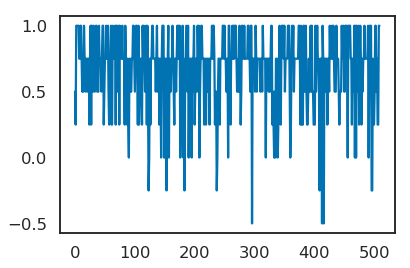

In [74]:
plt.plot(memory_benefits)

In [118]:
from scipy.stats import pearsonr

In [106]:
# compute ambiguity for each trial

n_p_shared_mu = np.mean(n_p_shared, axis=1)
n_p_shared_mu_uniques = np.unique(n_p_shared_mu)
n_mu = len(n_p_shared_mu_uniques)

n_p_shared_max = np.max(n_p_shared, axis=1)
n_p_shared_max_uniques = np.unique(n_p_shared_max)
n_max = len(n_p_shared_max_uniques)

In [119]:
# split memory benefit

splitter = n_p_shared_max
splitter_vals = n_p_shared_max_uniques
n = n_max

# splitter = n_p_shared_mu
# splitter_vals = n_p_shared_mu_uniques
# n = n_mu

mb_mu_by_sp = [
    np.mean(memory_benefits[splitter == k])
    for k in splitter_vals
]
mb_se_by_sp = [
    sem(memory_benefits[splitter == k]) * n_se
    for k in splitter_vals
]

# compute RT
rt_thres = 3
rts = np.zeros((n_trial_types, n_trials[j]))
for j in range(n_trial_types):
    for i in range(n_trials[j]):
        rts[j, i] = compute_rt(corrects[j][i], rt_thres, p.env.event_len)
rts_mu_by_sp = [
    [np.mean(rts[j, splitter == k]) for k in splitter_vals]
    for j in range(n_trial_types)
]
rts_se_by_sp = [
    [sem(rts[j, splitter == k]) * n_se for k in splitter_vals]
    for j in range(n_trial_types)
]

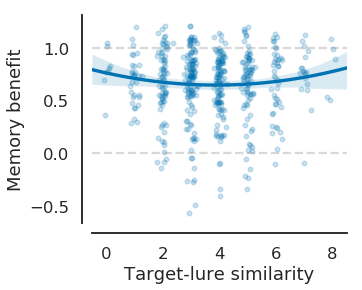

In [121]:
# f, ax = plt.subplots(1, 1, figsize=(5, 4))
# ax.bar(x=range(n), height=mb_mu_by_sp, yerr=mb_se_by_sp)
# ax.set_xticks(range(n))
# ax.set_xticklabels([int(z) for z in n_p_shared_max_uniques])
# ax.set_title('Performance ~ ambiguity')
# ax.set_xlabel('Target-lure similarity')
# ax.set_ylabel('Memory benefit')
# f.tight_layout()
# sns.despine()

# sns.jointplot(x=n_p_shared_mu, y=memory_benefits, kind="kde")
# [r, p] = pearsonr(n_p_shared_mu, memory_benefits)
# sns.jointplot(x=n_p_shared_max, y=memory_benefits, kind="kde")

# sns.distplot(n_p_shared_mu[memory_benefits< 0])

f, ax = plt.subplots(1, 1, figsize=(5, 4))
[r, p_val] = pearsonr(n_p_shared_mu, memory_benefits)
jit_scale = 0.1
x_jit = np.random.normal(size=(n_trials[j]), scale=jit_scale)
y_jit = np.random.normal(size=(n_trials[j]), scale=jit_scale)
ax.scatter(
    x=n_p_shared_mu+x_jit,
    y=memory_benefits+y_jit,
    marker='.', alpha=.2
)
sns.regplot(
    x=n_p_shared_mu, y=memory_benefits,
    scatter=False, order=2, ci=99,
)
ax.axhline(1, color='grey', linestyle='--', alpha=.3)
ax.axhline(0, color='grey', linestyle='--', alpha=.3)
title_text = f"""Performance ~ ambiguity
r = %.2f, p = %.5f
""" % (r, p_val)
# ax.set_title(title_text)
ax.set_xlabel('Target-lure similarity')
ax.set_ylabel('Memory benefit')
f.tight_layout()
sns.despine(offset=10)
# img_name = f'e{epoch_load}_mb-amb.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

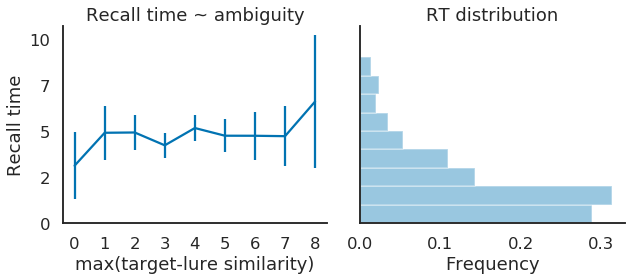

In [115]:
f, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

axes[0].errorbar(
    x=range(n), y=rts_mu_by_sp[j],
    yerr=rts_se_by_sp[j]
)
axes[0].set_xticks(range(n))
axes[0].set_ylim([0, None])
axes[0].set_xticklabels([int(z) for z in n_p_shared_max_uniques])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
axes[0].set_title('Recall time ~ ambiguity')
axes[0].set_xlabel('max(target-lure similarity)')
axes[0].set_ylabel('Recall time')

sns.distplot(
    rts[0],
    bins=int(np.max(rts)-np.min(rts)),
    norm_hist=True,
    kde=False,
    vertical=True,
    # kde=True, kde_kws={'bw': .6},
    ax=axes[1]
)
axes[1].set_xlabel('Frequency')
axes[1].set_title('RT distribution')

f.tight_layout()
sns.despine()
# img_name = f'e{epoch_load}_rt-amb.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

In [116]:
"""compute target-lure similarity, split by amb level"""

amb_bound = np.median(n_p_shared_max_uniques)
amb_high_ = n_p_shared_max_uniques[n_p_shared_max_uniques > amb_bound]
amb_high = np.array([i in amb_high_ for i in n_p_shared_max])
amb_low = np.logical_not(amb_high)

In [117]:
'''signal detction metric - max score, compare target vs. lure in R trials
'''

# n_bins = 100
# histrange = (0, 1)

# # max_acts = np.max(model_sim, axis=2)
# tprs, fprs, auc = compute_auc_over_time(
#     model_sim_r_lure, model_sim_r_targ,
#     n_bins=n_bins, histrange=histrange
# )
# # np.shape(model_sim_r_lure)
# # np.shape(model_sim_r_targ)

# cur_pal = sns.color_palette('Blues', n_colors=n_param)

# f, axes = plt.subplots(2, 1, figsize=(5, 7))
# for t in range(n_param):
#     axes[0].plot(fprs[t], tprs[t], color=cur_pal[t])
# axes[0].set_xlabel('FPR')
# axes[0].set_ylabel('TPR')
# axes[0].set_title('ROC curves over time')
# axes[0].plot([0, 1], [0, 1], linestyle='--', color='grey')

# axes[1].plot(auc, color='black')
# axes[1].set_xlabel('Time')
# axes[1].set_ylabel('AUC')
# # axes[1].set_title('AUC over time, mean = %.2f' % (np.mean(auc)))
# axes[1].set_title('AUC over time')
# axes[1].axhline(.5, linestyle='--', color='grey')
# axes[1].set_ylim([.4, 1.05])

# for ax in axes:
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# axes[1].xaxis.set_major_formatter(FormatStrFormatter('%d'))
# f.tight_layout()
# sns.despine()

# img_name = f'e{epoch_load}-r-tl-auc.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

# # np.shape(data_plt)
# d_pack = [model_sim_r_targ, model_sim_r_lure]
# np.shape(model_sim_r_targ)
# n_bins = 50
# # vmin = np.min(data_plt)
# # vmax = np.max(data_plt)
# vmin = np.min(max_acts[:, t, :])
# vmax = np.max(max_acts[:, t, :])
# bw = (vmax - vmin) / n_bins

# for t in range(n_param):
#     f, ax = plt.subplots(1, 1, figsize=(6, 3))
#     for j in range(n_trial_types):
#         p = sns.kdeplot(
#             d_pack[j][t, :],
#             shade=True,
#             bw=bw,
#             ax=ax,
#             color=tl_pals[j]
#         )
#         # p = sns.distplot(
#         #     max_acts[j, t, :],
#         #     kde=False,
#         #     bins=n_bins,
#         #     # shade=True,
#         #     # bw=bw,
#         #     ax=ax
#         # )
#     ax.set_title('Target lure distributions, recall trials')
#     ax.set_xlabel('Recall strength')
#     ax.set_ylabel('Counts')
#     # ax.set_xlim([-.2, 1.2])
#     # ax.set_xlim([vmin*.9, vmax*1.1])
#     # ax.set_ylim([0, 190])
#     # f.legend(CONDITIONS, frameon=False)
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     # f.tight_layout()
#     sns.despine()
#     img_name = f'e{epoch_load}_r-tl-dist-t{t}.png'
#     f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

'signal detction metric - max score, compare target vs. lure in R trials\n'